In [ ]:
import time
import copy

import torch
from torch.nn import Module
from torch.optim import Optimizer, Adam
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import LRScheduler, StepLR

from data_loading.dataset import generate_dataloaders
from metrics.iou import calculate_iou, CHAOSIoUTracker
from metrics.loss import LossTracker, calculate_loss
from unet import UNet

## Hyperparameters

In [ ]:
N_CLASSES = 4
BATCH_SIZE = 32
N_EPOCHS = 50
LR = .001
WEIGHT_DECAY = .0001
STEP_SIZE = 30

## Generating Dataloaders for feeding the NN

In [ ]:
dataloaders = generate_dataloaders(batch_size=BATCH_SIZE, validation_split=0.20)

## Model Definition

In [ ]:
model = UNet(n_classes=N_CLASSES)

## Log Functions

In [ ]:
def print_metric_to_console(name: str, train_metric: dict, valid_metric: dict) -> None:
    """
    Formats and prints training and validation metric values to console.
    Expected metric dict:
        {
        "metric1": metric_value1,
        "metric2": metric_value2,
        "metric3": metric_value3,
        ... }
    """
    print(f"{name.upper()}:")
    metric_dict = {"train": train_metric, "valid": valid_metric}
    for phase, metric in metric_dict.items():
        output = " ".join(f"{cls}: {score:.5f}" for cls, score in metric.items())
        print(f"\t({phase}) {output}")


def print_metric_to_tb(writer: SummaryWriter, train_metric: dict, valid_metric: dict, epoch: int) -> None:
    """
    Prints training and validation metric values to Tensorboard.
    Expected metric dict:
        {
        "metric1": metric_value1,
        "metric2": metric_value2,
        "metric3": metric_value3,
        ... }
    """
    for cls in train_metric.keys():
        scalar_dict = {
            "train": train_metric[cls],
            "valid": valid_metric[cls]
        }
        writer.add_scalars(main_tag=cls, tag_scalar_dict=scalar_dict, global_step=epoch)


WRITER_LOSS = SummaryWriter("logs/loss")
WRITER_ACCURACY = SummaryWriter("logs/accuracy")

## Training Loop

In [ ]:
def generate_run_name(
        model_name: str,
        epochs: int,
        batch_size: int,
        lr: float,
        step_size: int,
        weight_decay: float
) -> str:
    timestamp = time.strftime("%Y-%m-%d_%H-%M-%S")
    return f"{model_name}_EP{epochs}_BS{batch_size}_LR{lr}_Step{step_size}_WD{weight_decay}_{timestamp}"


def train_model(
        model: Module,
        dataloaders: dict,
        n_epochs: int,
        optimizer: Optimizer,
        scheduler: LRScheduler,
        device: torch.device = torch.device("cpu")
) -> None:
    model.to(device)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(n_epochs):
        print(f"\nEpoch {epoch + 1}/{n_epochs}\n{'=' * 30}")
        print(f"LR: {optimizer.param_groups[0]['lr']}")

        start_time = time.time()

        for phase in ["train", "valid"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            loss_tracker = LossTracker()
            accuracy_tracker = CHAOSIoUTracker()

            with torch.set_grad_enabled(phase == "train"):
                for images, masks in dataloaders[phase]:
                    images, masks = images.to(device), masks.to(device)

                    optimizer.zero_grad()
                    prediction = model(images)

                    loss = calculate_loss(prediction=prediction, ground_truth=masks)
                    loss_tracker.update(losses=loss, batch_size=masks.size(0))

                    iou_score = calculate_iou(prediction=prediction, ground_truth=masks)
                    accuracy_tracker.update(batch_iou=iou_score, batch_size=masks.size(0))

                    if phase == "train":
                        loss["loss"].backward()
                        optimizer.step()

            avg_loss = loss_tracker.get_results()
            avg_accuracy = accuracy_tracker.get_results()

            if phase == "train":
                train_loss = avg_loss  # save the training loss
                train_accuracy = avg_accuracy  # save the training accuracy
            else:
                # print loss
                print_metric_to_console(name="LOSS", train_metric=train_loss, valid_metric=avg_loss)
                print_metric_to_tb(writer=WRITER_LOSS, train_metric=train_loss, valid_metric=avg_loss, epoch=epoch)

                # print accuracy
                print_metric_to_console(
                    name="ACCURACY(IoU)",
                    train_metric=train_accuracy,
                    valid_metric=avg_accuracy
                )
                print_metric_to_tb(
                    writer=WRITER_ACCURACY,
                    train_metric=train_accuracy,
                    valid_metric=avg_accuracy,
                    epoch=epoch
                )
                if avg_loss["loss"] < best_loss:
                    print("Saving best model...")
                    best_loss = avg_loss["loss"]
                    best_model_wts = copy.deepcopy(model.state_dict())

        finish_time = round(time.time() - start_time)
        print(f"TIME: {finish_time // 60}min {finish_time % 60}s")
        scheduler.step()

    print(f"Best validation loss: {best_loss:.5f}")
    model.load_state_dict(best_model_wts)

    run_name = generate_run_name(model_name="UNet",
                                 weight_decay=WEIGHT_DECAY,
                                 lr=LR,
                                 step_size=STEP_SIZE,
                                 batch_size=BATCH_SIZE,
                                 epochs=N_EPOCHS
                                 )

    torch.save(model.state_dict(), f"./models/{run_name}.pth")


In [ ]:
%reload_ext tensorboard
%tensorboard --logdir logs/losses

In [ ]:
%tensorboard --logdir logs/accuracies

## Define Optimizer, LR Scheduler and Start Training

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR, weight_decay=WEIGHT_DECAY)
lr_scheduler = StepLR(optimizer=optimizer, step_size=STEP_SIZE, gamma=0.1)

train_model(
    model=model,
    dataloaders=dataloaders,
    n_epochs=N_EPOCHS,
    optimizer=optimizer,
    scheduler=lr_scheduler,
    device=device
)

# MODEL EVALUATION


In [234]:
import random
from pathlib import Path

import pydicom
import numpy as np
import matplotlib.pyplot as plt
from torch import Tensor

from data_preprocessing import IMAGE_PREPROCESSING_PIPELINE

In [236]:
model_path = "./models/MODEL_NAME"  # add name of the model
model = UNet(n_classes=N_CLASSES)
model.eval()
model.load_state_dict(torch.load(model_path, weights_only=True))

<All keys matched successfully>

In [239]:
def binary_stack_to_rgb_image(mask: np.array) -> np.array:
    channels, height, width = mask.shape
    colored_img = np.zeros((height, width, 3), dtype=np.uint8)

    colors = np.array([
        (201, 58, 64),  # Red - Liver
        (242, 207, 1),  # Yellow - Right Kidney
        (0, 152, 75),  # Green - Left Kidney
        (101, 172, 228)  # Blue - Spleen
    ], dtype=np.uint8)

    for class_index in range(channels):
        colored_img[mask[class_index]] = colors[class_index]

    return colored_img


def plot_valid_sample(image: Tensor, ground_truth: Tensor, prediction: Tensor, threshold: float = 0.5) -> None:
    image, ground_truth = image.numpy(), ground_truth.numpy()
    prediction = prediction.detach().numpy()

    ground_truth, prediction = ground_truth > threshold, prediction > threshold

    ground_truth_colored = binary_stack_to_rgb_image(mask=ground_truth)
    prediction_colored = binary_stack_to_rgb_image(mask=prediction)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    ax[0].imshow(image.transpose(1, 2, 0))
    ax[0].set_title("DICOM Image")
    ax[0].axis("off")

    ax[1].imshow(image.transpose(1, 2, 0))
    ax[1].imshow(ground_truth_colored, alpha=0.5)  # show transparent GT over DICOM image
    ax[1].set_title("Ground Truth")
    ax[1].axis("off")

    ax[2].imshow(prediction_colored)
    ax[2].set_title("Prediction")
    ax[2].axis("off")

    plt.show()


def plot_test_sample(image: Tensor, prediction: Tensor, threshold: float = 0.5) -> None:
    image = image.numpy()
    prediction = prediction.detach().numpy() > threshold

    prediction_colored = binary_stack_to_rgb_image(mask=prediction)

    plt.imshow(image.transpose(1, 2, 0))
    plt.imshow(prediction_colored, alpha=0.5)  # show transparent prediction over DICOM image
    plt.axis("off")
    plt.title("DICOM Image + Prediction")

    plt.show()

def load_test_image() -> np.array:
    test_data_root = Path("./CHAOS dataset/test/MR/")

    patient_ids = [p for p in test_data_root.iterdir()]
    random_patient = random.choice(patient_ids)

    patient_root = random_patient / "T1DUAL/DICOM_anon/InPhase"

    image_files = list(patient_root.iterdir())
    random_image_path = random.choice(image_files)

    return np.array(pydicom.dcmread(random_image_path).pixel_array, dtype=np.float32)


## Display Predictions on Validation Dataset

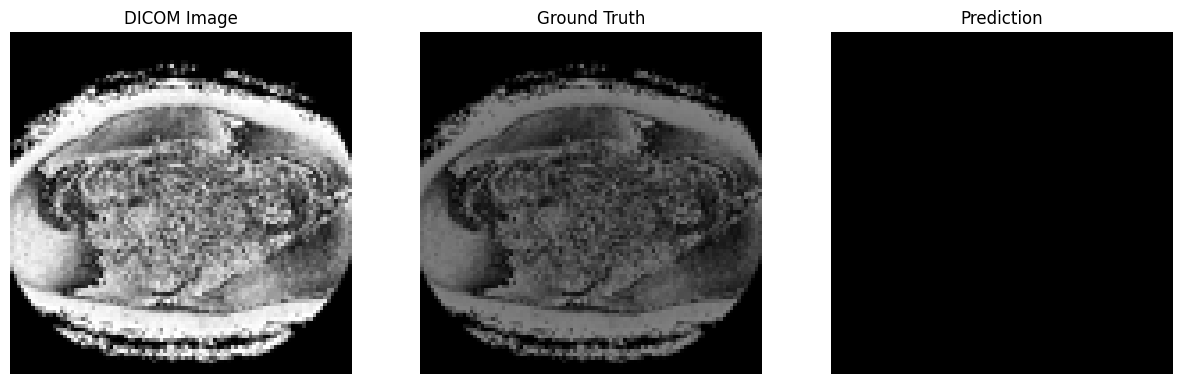

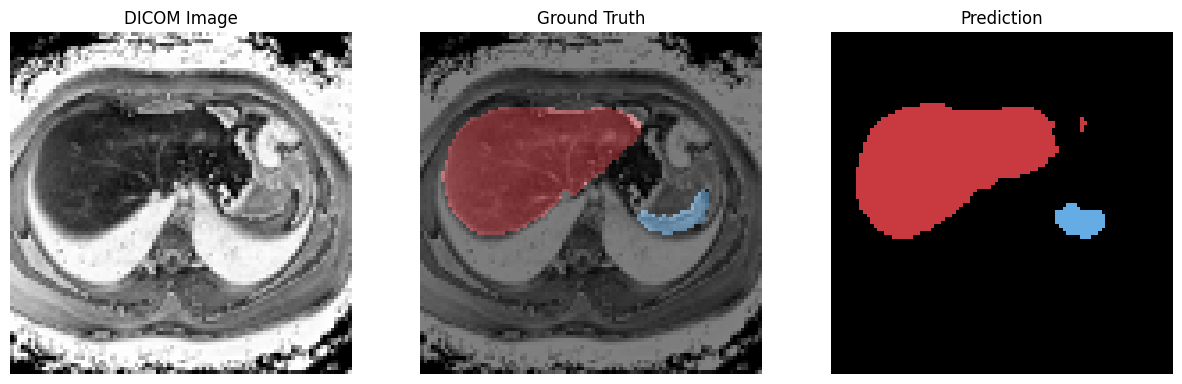

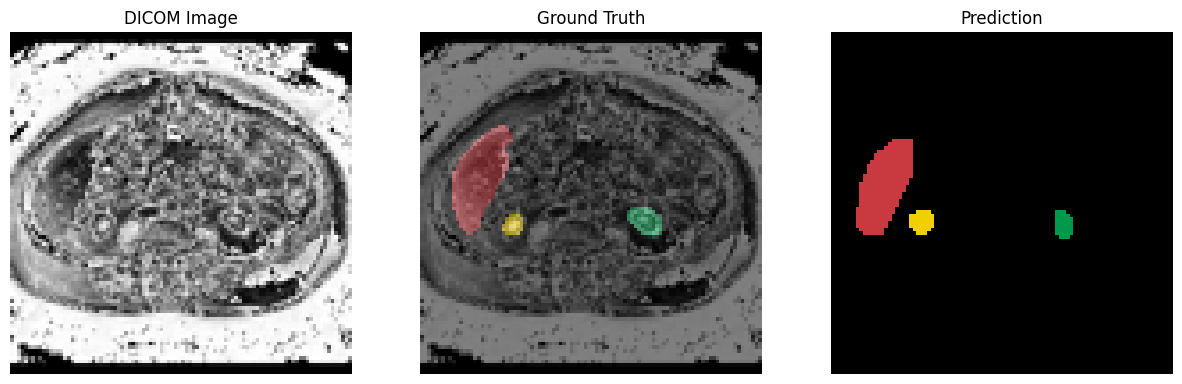

In [242]:
n_samples = 3
threshold = 0.5

for _ in range(n_samples):
    images, masks = next(iter(dataloaders["valid"]))
    random_index = random.randint(0, masks.size(0) - 1)

    predictions = model(images)
    predictions = torch.sigmoid(predictions)

    plot_valid_sample(
        image=images[random_index],
        ground_truth=masks[random_index],
        prediction=predictions[random_index],
        threshold=threshold
    )

## Display Predictions on Test Dataset

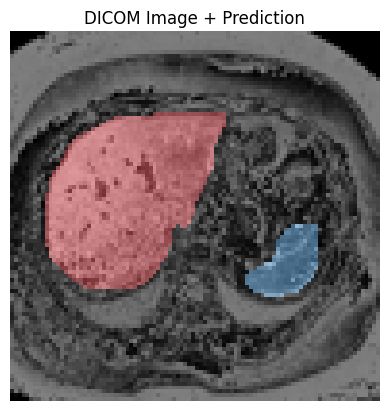

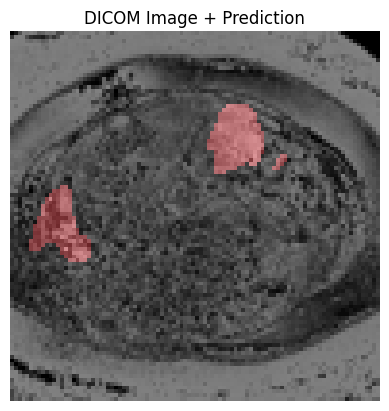

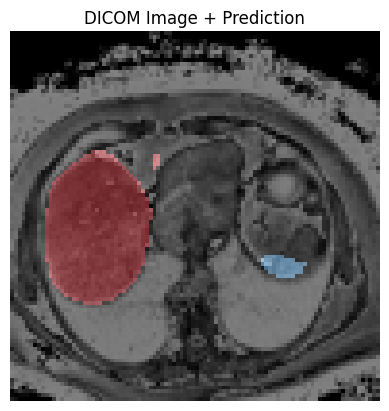

In [245]:
n_samples = 3
threshold = 0.5

images = []
for _ in range(n_samples):
    images.append(IMAGE_PREPROCESSING_PIPELINE(load_test_image()))

images = torch.stack(images)
predictions = model(images)
predictions = torch.sigmoid(predictions)

for i in range(n_samples):
    plot_test_sample(image=images[i], prediction=predictions[i], threshold=threshold)